In [1]:
!source switch-cuda 11.7

# Core dependencies
import jax
import jax.numpy as jnp
import optax
import numpy as np

# pcax
import pcax as px # same as import pcax.pc as px
import pcax.nn as nn
from pcax.core import _

# Environment variables
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

Switched to CUDA 11.7.


In [2]:
class Model(px.Module):
    def __init__(self, input_dim, hidden_dim, output_dim) -> None:
        super().__init__()

        self.act_fn = jax.nn.tanh

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, output_dim)

        self.pc0 = px.Layer()
        self.pc1 = px.Layer()
        self.pc2 = px.Layer()
        self.pc3 = px.Layer()

        self.pc3.x.frozen = True

    def __call__(self, x, t=None):
        x = self.pc0(x)["x"]
        x = self.pc1(self.act_fn(self.linear1(x)))["x"]
        x = self.pc2(self.act_fn(self.linear2(x)))["x"]
        x = self.pc3(self.linear3(x))["x"]

        if t is not None:
            self.pc3["x"] = t

        return self.pc3["u"]

In [3]:
from sklearn.datasets import make_moons

def create_data(params, rkey):
    rkey1, rkey2 = jax.random.split(rkey)
    if params["dataset"] == "xor":
        x_dataset = jax.random.randint(rkey1, (params["num_batches"], params["batch_size"], 2), 0, 2)
        y_dataset = ((jnp.sum(x_dataset, axis=-1) % 2)[:, :, None]  == jnp.arange(2)).astype(jnp.float32)
        x_dataset = x_dataset.astype(jnp.float32) + jax.random.normal(rkey2, (params["num_batches"], params["batch_size"], 2)) * params["data_noise"]
    elif params["dataset"] == "two_moons":
        x_dataset, y_dataset = make_moons(n_samples=params["batch_size"], shuffle=True, noise=params["data_noise"], random_state=rkey[0].item())
        y_dataset = np.stack([1- y_dataset, y_dataset], axis=1)
        x_dataset, y_dataset = jnp.array(x_dataset), jnp.array(y_dataset).astype(jnp.float32)
        x_dataset, y_dataset = jnp.expand_dims(x_dataset, axis=0), jnp.expand_dims(y_dataset, axis=0)
    else:
        raise NotImplementedError(f"Dataset not implemented: {params['dataset']}")
    return x_dataset, y_dataset

def create_grid_data(x_min: float= -3.0, x_max: float = 3.0, y_min = -3.0, y_max: float = 3, num: int = 128) -> jnp.ndarray:
    x = jnp.linspace(x_min, x_max, num)
    y = jnp.linspace(y_min, y_max, num)
    xx, yy = jnp.meshgrid(x, y)
    return jnp.c_[xx.ravel(), yy.ravel()]

def batch_generator(x: jnp.array, y: jnp.array, batch_size: int):
    for i in range(x.shape[0] // batch_size):
        x_batch = x[i*batch_size:(i+1)*batch_size]
        y_batch = y[i*batch_size:(i+1)*batch_size] if y is not None else None
        yield x_batch, y_batch

In [4]:
params = {
    "dataset": "xor",
    "data_noise": 0.03,
    "num_epochs": 128,
    "hidden_dim": 16,
    "num_batches": 32,
    "batch_size": 128,
    "T": 8,

    "optim_x_l2": 0.0,
    "optim_x_lr": 0.5,
    "optim_w_l2": 0.0,
    "optim_w_lr": 5e-3,
    "optim_w_momentum": 0.9,
    "optim_w_nesterov": True,

    "init_train": {
        "init_rand_weight": 0,
        "init_forward_weight": 1.0,
        "init_constant": 0,
        "init_constant_weight": 0,
    },
    "init_test": {
        "init_rand_weight": 0,
        "init_forward_weight": 0,
        "init_constant": 0.5,
        "init_constant_weight": 1.0,
    },

    "logs_plot_kwargs": {},
}

model = Model(2, params["hidden_dim"], 2)

In [5]:
@px.vectorize(_(px.NodeVar), in_axis=(0, 0))
@px.bind(model)
def predict(x, t):
    return model(x, t)

@px.vectorize(_(px.NodeVar), in_axis=(0, ), out_axis=("sum",))
@px.bind(model)
def loss(x):
    y = model(x)
    return model.energy

In [6]:
with px.init_nodes(model, np.zeros((params["batch_size"], 2)), None):
    optim_x = px.Optim(
        optax.chain(
            optax.add_decayed_weights(weight_decay=params["optim_x_l2"]),
            optax.sgd(params["optim_x_lr"])
        ),
        model.vars(_(px.NodeVar)(frozen=False))
    )
    optim_w = px.Optim(
        optax.chain(
            optax.add_decayed_weights(weight_decay=params["optim_w_l2"]),
            optax.sgd(params["optim_w_lr"] / params["batch_size"], momentum=params["optim_w_momentum"], nesterov=params["optim_w_nesterov"])
        ),
        model.vars(_[px.TrainVar, -_(px.NodeVar)]),
    )

In [7]:
def get_node_initiator(params):
    def node_initiator(input = None, shape = None, key = None):
        if shape is None:
            shape = input.shape
        if input is None:
            input = jnp.zeros(shape)
        r = jax.random.normal(key, shape) * params["init_rand_weight"]
        d = input * params["init_forward_weight"]
        c = jnp.full(shape, params["init_constant"]) * params["init_constant_weight"]
        return r + d + c
    return node_initiator

In [8]:
@px.jit()
@px.bind(model, optim_x)
def free_test_on_batch(t, x, loss, T, init_node):
    with px.init_nodes(model, init_node(t, t.shape, px.core.DEFAULT_GENERATOR()), x):
        for i in range(T):
            with px.init_cache(model):
                g, (l,) = px.gradvalues(
                    _(px.NodeVar)(frozen=False),
                )(loss)(model.pc0["x"])
                
                optim_x(g)
        
        y = model.pc0["x"]
    
    target_class = jnp.argmax(t, axis=1)
    predicted_class = jnp.argmax(y, axis=1)
    accuracy = jnp.mean(predicted_class == target_class)

    return accuracy

In [9]:
@px.jit()
@px.bind(model, optim_x=optim_x, optim_w=optim_w)
def train_on_batch(t, x, loss, T, init_node):
    with px.init_nodes(model, init_node(t, t.shape, px.core.DEFAULT_GENERATOR()), x):
        for i in range(T):
            with px.init_cache(model):
                g, (l,) = px.gradvalues(
                    _(_(px.NodeVar)(frozen=False), _[px.TrainVar, -_(px.NodeVar)]),
                )(loss)(model.pc0["x"])

                optim_x(g)
                optim_w(g)

            # with px.train(model):
            #     g, (l,) = px.gradvalues(
            #         _[px.TrainVar, -_(px.NodeVar)],
            #     )(loss)(t)
                
            #     optim_w(g)

        y = model.pc0["x"]

    target_class = jnp.argmax(t, axis=1)
    predicted_class = jnp.argmax(y, axis=1)
    accuracy = jnp.mean(predicted_class == target_class)

    return accuracy

In [10]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

@px.bind(model, optim_x=optim_x, optim_w=optim_w)
def main(params) -> None:
    # initialise data
    x_dataset, y_dataset = create_data(params, px.core.DEFAULT_GENERATOR())
    x_test_dataset = create_grid_data(**params["logs_plot_kwargs"])
    assert x_test_dataset.shape[0] % params["batch_size"] == 0

    # select testing method
    test_on_batch = free_test_on_batch

    train_output_per_epoch = []
    test_output_per_epoch = []

    # these functions are used to initialise the first layer.
    node_init_train = get_node_initiator(params["init_train"])
    node_init_test = get_node_initiator(params["init_test"])

    with tqdm(range(params["num_epochs"]), unit="epoch") as tepoch:
        for epoch in tepoch:
            tepoch.set_description(f"Train Epoch {epoch + 1}")

            # train
            outputs = []
            for (x, y) in zip(x_dataset, y_dataset):
                output = train_on_batch(
                    loss=loss,
                    T=params["T"],
                    init_node=node_init_train,
                )(
                    y, x
                )
                outputs.append(output)

            train_output_per_epoch.append(np.mean(outputs).item())

            # test
            outputs = []
            for (x, y) in zip(x_dataset, y_dataset):
                output = test_on_batch(
                    loss=loss,
                    T=params["T"],
                    init_node=node_init_test,
                )(
                    y, x
                )
                outputs.append(output)

            test_output_per_epoch.append(np.mean(outputs).item())

            # todo: add loss, and energy to tqdm bar, add lr_x and lr_w
            tepoch.set_postfix(accuracy=test_output_per_epoch[-1])

    # plot training loss and test accuracy
    plt.clf()
    sns.set_theme()
    fig = sns.lineplot(x=range(params["num_epochs"]), y=np.full_like(range(params["num_epochs"]), 0.866, dtype=float), label="Linear Classifier Accuracy = 0.866", color="red")
    fig = sns.lineplot(x=range(params["num_epochs"]), y=test_output_per_epoch, label="Test Accuracy", linewidth = 0.5)
    fig.set(ylim=(0, 1.01), title=f"Test Accuracy. Max={max(test_output_per_epoch):.3f} at epoch {test_output_per_epoch.index(max(test_output_per_epoch))}.")
    plt.show()

Train Epoch 128: 100%|██████████| 128/128 [00:42<00:00,  3.03epoch/s, accuracy=1]    


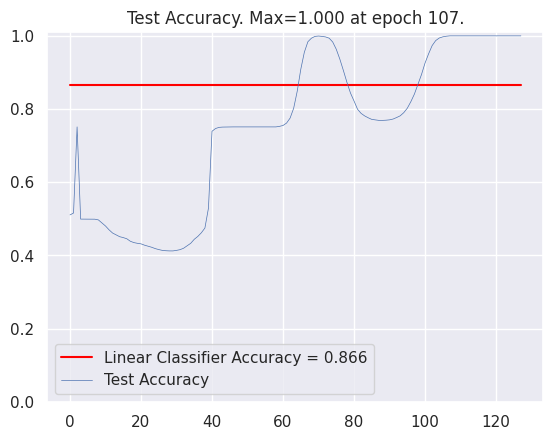

In [11]:
main(params)